In [84]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [85]:
import tensorflow as tf
import os

In [86]:
os.path.join('data', 'happy')

'data/happy'

In [87]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [88]:
data_dir = 'data'

In [89]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [90]:
image_exts

['jpeg', 'jpg', 'bmp', 'png']

In [91]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [92]:
import numpy as np

In [93]:
data = tf.keras.utils.image_dataset_from_directory('data', batch_size=20)

Found 305 files belonging to 2 classes.


In [94]:
data_iterator = data.as_numpy_iterator()

In [95]:
batch = data_iterator.next()

### 0 - happy
### 1 - sad

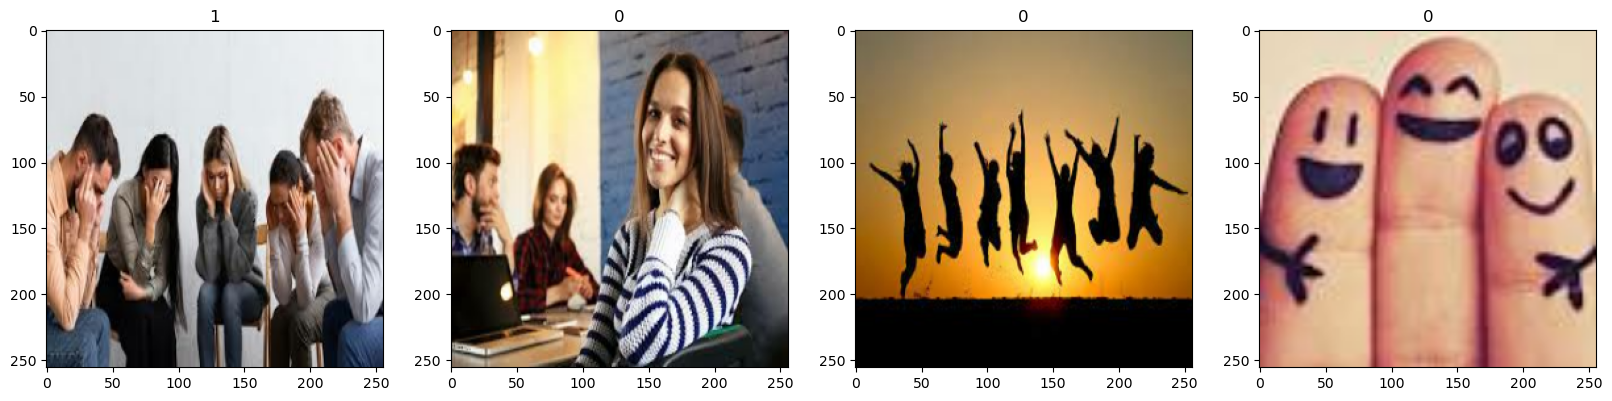

In [96]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# data preprocessing

In [97]:
# scale data

data = data.map(lambda x, y: (x/255, y))

In [98]:
scaled_iterator = data.as_numpy_iterator()

In [99]:
batch = scaled_iterator.next()

In [100]:
batch[0].max()

1.0

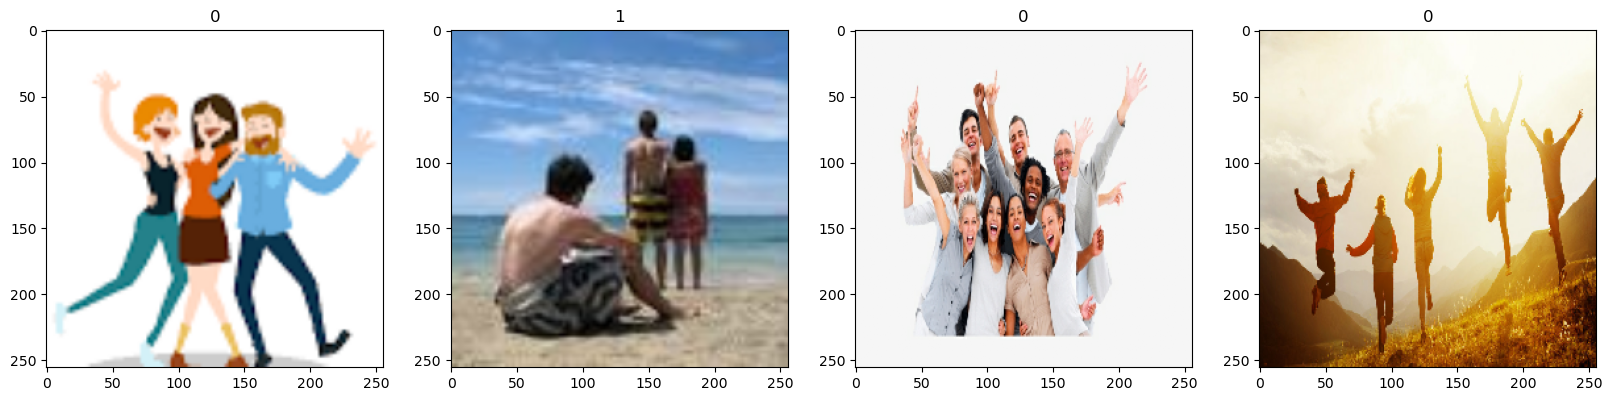

In [101]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

#### split data

In [102]:
len(data)

16

In [103]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [104]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### model selection

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [106]:
model = Sequential()

In [107]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [108]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [109]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

### train model

In [110]:
logdir = 'logs'

In [111]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [112]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


11/11 [==============================] - 32s 3s/step - loss: 0.8764 - accuracy: 0.5227 - val_loss: 0.6737 - val_accuracy: 0.6167
Epoch 2/20
11/11 [==============================] - 24s 2s/step - loss: 0.6158 - accuracy: 0.6591 - val_loss: 0.5507 - val_accuracy: 0.7500
Epoch 3/20
11/11 [==============================] - 24s 2s/step - loss: 0.5721 - accuracy: 0.7045 - val_loss: 0.4501 - val_accuracy: 0.8667
Epoch 4/20
11/11 [==============================] - 23s 2s/step - loss: 0.4835 - accuracy: 0.7955 - val_loss: 0.4006 - val_accuracy: 0.8333
Epoch 5/20
11/11 [==============================] - 24s 2s/step - loss: 0.3984 - accuracy: 0.8045 - val_loss: 0.4685 - val_accuracy: 0.7167
Epoch 6/20
11/11 [==============================] - 24s 2s/step - loss: 0.3737 - accuracy: 0.8455 - val_loss: 0.3347 - val_accuracy: 0.9167
Epoch 7/20
11/11 [==============================] - 22s 2s/step - loss: 0.2553 - accuracy: 0.9455 - val_loss: 0.2500 - val_accuracy: 0.8833
Epoch 8/20
11/11 [=============

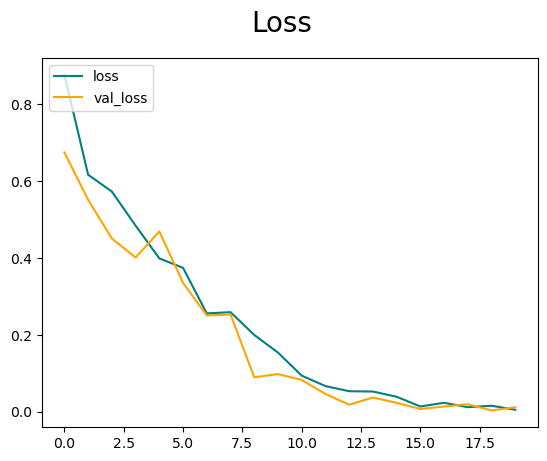

In [124]:
# plot model performance

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

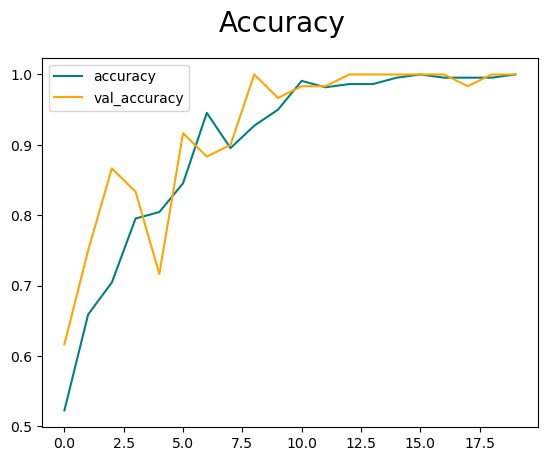

In [114]:
# plot model performance

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [125]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [126]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [127]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 287ms/step


In [128]:
print(f'Precision:{pre.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy;{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy;1.0


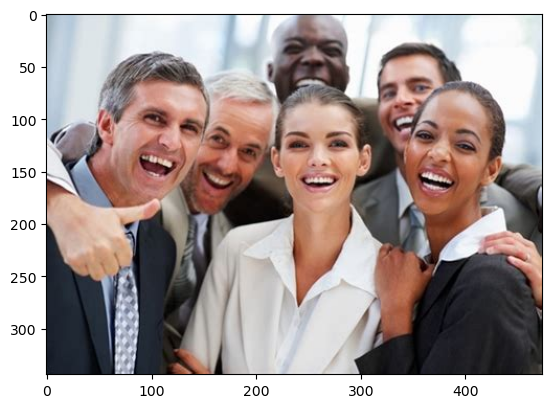

In [129]:
# test

img = cv2.imread('happy2.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

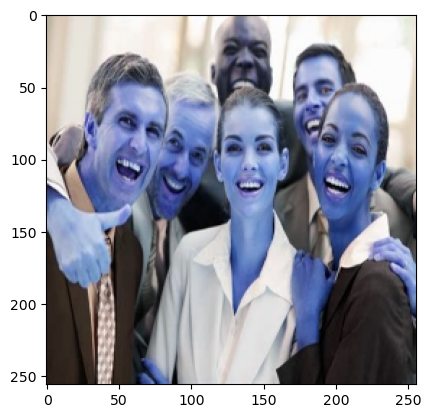

In [130]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [131]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 56ms/step


In [132]:
yhat

array([[0.92585987]], dtype=float32)

In [134]:
if yhat > 0.5:
    print('Happy')
else:
    print('Sad')

Happy


In [137]:
os.path.join('models', 'imageclassificationmodel.h5')

'models/imageclassificationmodel.h5'

In [136]:
# save the model

from tensorflow.keras.models import load_model

model.save(os.path.join('models', 'imageclassificationmodel.h5'))

/home/mahbub/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [138]:
new_model = load_model(os.path.join('models', 'imageclassificationmodel.h5'))

In [139]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 1s 628ms/step


array([[0.92585987]], dtype=float32)